In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline
from sklearn.feature_selection import RFE,RFECV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, log_loss,classification_report
rcParams['figure.figsize'] = 15,6
#Logistic regression
from sklearn.linear_model import LogisticRegression
#Random forest 
from sklearn.ensemble import RandomForestClassifier
#SVM
from sklearn.svm import SVC
#Xgboost
from xgboost import XGBClassifier
#Gridsearch
from sklearn.model_selection import GridSearchCV


In [2]:
#chargement du dataset
df = pd.read_csv('35users.csv', index_col=0)
df['Subject'] = df['Subject'].replace(np.NaN, 'None')
df['Thread']=''
df.rename(columns={"DATE": "Date_2","TIME":"if_time_mention"},inplace=True)
df.drop_duplicates(subset=['From','To','Cc','X-bcc','Subject','Mail'],inplace=True)
df.Date=pd.to_datetime(df.Date)
#df=df[df.user=='dasovich-j']

In [3]:
df['Subject_not_clean']=df['Subject']
df['Mail_not_clean']=df['Mail']

In [4]:
df.head()

,Date,From,To,Cc,X-bcc,Subject,Mail,user,polarity,word_count_Mail,...,Date_2,if_time_mention,GPE,EVENT,MONEY,FAC,WORK_OF_ART,Thread,Subject_not_clean,Mail_not_clean
0,1998-12-07 08:00:00,jeff.dasovich@enron.com,None,No Cc,NaN,Edison/interconnection,"When: Monday, December 07, 1998 10:30 AM-12:00...",dasovich-j,0.000000,26,...,1,1,2,0,0,1,0,,Edison/interconnection,"When: Monday, December 07, 1998 10:30 AM-12:00..."
1,1999-04-01 16:39:00,marc.phillips@enron.com,"kyle.purvis@enron.com, allan.weatherford@enron...","william.kendrick@enron.com, david.nutt@enron.c...",NaN,Texas Compliance Certification Forms Reminder,I was at a TXOGA meeting last week and I was i...,campbell-l,-0.093750,116,...,3,0,1,0,0,0,0,,Texas Compliance Certification Forms Reminder,I was at a TXOGA meeting last week and I was i...
2,1999-04-02 08:06:00,team.kingman-needles@enron.com,None,"rich.jolly@enron.com, david.roensch@enron.com,...",NaN,PG&E Sampleing Report,Notice the sample results are much higher than...,campbell-l,0.150000,16,...,1,0,0,0,0,0,0,,PG&E Sampleing Report,Notice the sample results are much higher than...
3,1999-04-02 11:15:00,team.san-juan-laplata@enron.com,larry.campbell@enron.com,rick.smith@enron.com,NaN,N.O.V. Updates,Here are the latest and greatest.,campbell-l,0.750000,6,...,0,0,0,0,0,0,0,,N.O.V. Updates,Here are the latest and greatest.
4,1999-04-03 12:45:00,michel.nelson@enron.com,"dave.schafer@enron.com, jeffery.fawcett@enron....",No Cc,NaN,PG&E Letter & Spreadsheet,--------------- cc:Mail Forwarded ------------...,campbell-l,-0.008333,277,...,7,2,0,0,1,1,0,,PG&E Letter & Spreadsheet,--------------- cc:Mail Forwarded ------------...


In [5]:
#Nettoyage des mails de certains symboles qui se rajoutent quand il y a une réponse
def  clean_subject(dataset, text_field):
    dataset[text_field] = dataset[text_field].apply(lambda elem: re.sub("\?{1,}", "", elem))
    dataset[text_field] = dataset[text_field].apply(lambda elem: re.sub("!{2,}", "", elem))
    dataset[text_field] = dataset[text_field].apply(lambda elem: re.sub("\t", " ", elem))  
    dataset[text_field] = dataset[text_field].apply(lambda elem: re.sub("\\'", "", elem))
    dataset[text_field] = dataset[text_field].apply(lambda elem: re.sub("AM", "am", elem))
    dataset[text_field] = dataset[text_field].apply(lambda elem: re.sub("PM", "pm", elem))
    dataset[text_field] = dataset[text_field].apply(lambda elem: re.sub("=", "", elem))
    dataset[text_field] = dataset[text_field].apply(lambda elem: re.sub("&", "", elem))
    dataset[text_field] = dataset[text_field].apply(lambda elem: re.sub("\[", "", elem))
    dataset[text_field] = dataset[text_field].apply(lambda elem: re.sub("\]", "", elem))
    dataset[text_field] = dataset[text_field].apply(lambda elem: re.sub("\/", "", elem))
    dataset[text_field] = dataset[text_field].apply(lambda elem: re.sub("'", "", elem))
    dataset[text_field] = dataset[text_field].apply(lambda elem: re.sub("\*", "", elem))
    dataset[text_field] = dataset[text_field].apply(lambda elem: re.sub("\(", "", elem))
    dataset[text_field] = dataset[text_field].apply(lambda elem: re.sub("\)", "", elem))
    dataset[text_field] = dataset[text_field].apply(lambda elem: re.sub(",", "", elem))
    dataset[text_field] = dataset[text_field].apply(lambda elem: re.sub("\> ", "", elem))
    dataset[text_field] = dataset[text_field].apply(lambda elem: re.sub("\< ", "", elem))
    dataset[text_field] = dataset[text_field].apply(lambda elem: re.sub("\<|\>", "", elem))
    dataset[text_field] = dataset[text_field].apply(lambda elem: re.sub("\<|\>", "", elem))
    dataset[text_field] = dataset[text_field].apply(lambda elem: re.sub("\-{2,}", "", elem))
    dataset[text_field] = dataset[text_field].apply(lambda elem: re.sub("\s{2,}", " ", elem,flags=re.I))  

    return dataset
df = clean_subject(df, "Subject")

In [6]:
#Nettoyage des mails de certains symboles qui se rajoutent quand il y a une réponse
def  clean_mail(dataset, text_field):
    dataset[text_field] = dataset[text_field].apply(lambda elem: re.sub("\t", " ", elem))  
    dataset[text_field] = dataset[text_field].apply(lambda elem: re.sub("\\'", "", elem))
    dataset[text_field] = dataset[text_field].apply(lambda elem: re.sub("See attached file:", "-", elem))
    dataset[text_field] = dataset[text_field].apply(lambda elem: re.sub("AM", "am", elem))
    dataset[text_field] = dataset[text_field].apply(lambda elem: re.sub("PM", "pm", elem))
    dataset[text_field] = dataset[text_field].apply(lambda elem: re.sub("\> ", "", elem))
    dataset[text_field] = dataset[text_field].apply(lambda elem: re.sub("\< ", "", elem))
    dataset[text_field] = dataset[text_field].apply(lambda elem: re.sub("\<|\>", "", elem))
    dataset[text_field] = dataset[text_field].apply(lambda elem: re.sub("\<|\>", "", elem))
    dataset[text_field] = dataset[text_field].apply(lambda elem: re.sub("\-{2,}", "", elem))
    dataset[text_field] = dataset[text_field].apply(lambda elem: re.sub("\s{2,}", " ", elem,flags=re.I))  
    return dataset
df = clean_mail(df, "Mail")

## **Item  : Suppression des threads**

### Avec cette fonction, on va sélectionner les emails qui sont un subject qui ont un value counts plus grand que 3

In [7]:
def selection_subject(dataset):
    liste_subject_check=[]
    liste_subject_sans_re_fwd_check=[]
    dataset_containing_re_fwd=dataset[dataset.Subject.str.contains('Re:|RE:|re:|fwd:|FW:|Fwd:|Fw:|FWD:')]
    for (indice,valeur) in zip(dataset_containing_re_fwd.Subject.value_counts().index,dataset_containing_re_fwd.Subject.value_counts().values):
        if valeur>=3 and valeur<=50:
            liste_subject_check.append(indice)
    for elem in liste_subject_check:
        liste_subject_sans_re_fwd_check.append(re.sub('Re: ?|RE: ?|re: ?|fwd: ?|FW: ?|Fwd: ?|Fw: ?|FWD: ?', "", elem))
    print("Il y a {} subjects à traiter".format(len(liste_subject_check)))
    return liste_subject_check,liste_subject_sans_re_fwd_check

### Fonction qui va checker si un mail est inclus dans son sous-dataset subject, elle ne retourne rien mais modifie la colonne Thread dans le dataset 

In [8]:
def if_existing(dataset,df2,df6,indice_mail_check,limite):
    m=0
    #string1 est pour le milieu de mail 
    lim1=int(len(df2.Mail[indice_mail_check])/2)-int(len(df2.Mail[indice_mail_check])/limite)
    lim2=int(len(df2.Mail[indice_mail_check])/2)+int(len(df2.Mail[indice_mail_check])/limite)
    
    dataset_check=df2.drop(indice_mail_check)
    string1=df2.Mail[indice_mail_check][lim1:lim2]
    
    #string2 est pour le milieu de mail 
    lim0_1=0
    lim0_2=70
    string2=df2.Mail[indice_mail_check][lim0_1:lim0_2]
    
    check_array1=[elem for elem in np.array(dataset_check.Mail.str.find(string1).values>-1)]
    check_array2=[elem for elem in np.array(dataset_check.Mail.str.find(string2).values>-1)]
    check_array3=[(elem1,elem2) for (elem1,elem2) in zip(check_array1,check_array2)]
    serie_check1 = pd.Series(check_array3, index = dataset_check.index) 
    
    #Check pr tout le mail si il est trop petit 
    check_array4=[elem for elem in np.array(dataset_check.Mail.str.find(df2.Mail[indice_mail_check]).values>-1)]
    serie_check2 = pd.Series(check_array4, index = dataset_check.index) 
    
    #Check mails agenda 
    check_agenda=df2.Mail[indice_mail_check].split('Proposed agenda')
    
    #Check pièce jointe
    check_piece_jointe=[df2.Mail[indice_mail_check].lower().find('.xls'),df2.Mail[indice_mail_check].lower().find('.doc'),\
                        df2.Mail[indice_mail_check].lower().find('.pdf'),df2.Mail[indice_mail_check].lower().find('.jpg'),\
                        df2.Mail[indice_mail_check].lower().find('.png'),df2.Mail[indice_mail_check].lower().find('.pp'),\
                        df2.Mail[indice_mail_check].lower().find('.dot'),df2.Mail[indice_mail_check].lower().find('.wpd')]
    
    #Check si tout le dataset_check est en 1
    check_all_one=set(dataset_check.Thread)
    
    #S'il n'y a pas de pièces jointes, on traite normalement, sinon on le garde 
    if max(check_piece_jointe)==-1:
        if check_all_one=={1}:
            True
        else:
            #Si le check du mail est trop petit len<30, on prend tout le mail 
            if len(string1)>30:
                if (True,True) in check_array3:
                    if len(check_agenda)==1:            
                        dataset.Thread[indice_mail_check]=1
                        df2.Thread[indice_mail_check]=1
                        df6.Thread[indice_mail_check]=1
                    else:
                        check_array5=[elem for elem in np.array(dataset_check.Mail.str.find(check_agenda[1][0:35]).values>-1)]
                        serie_check3 = pd.Series(check_array5, index = dataset_check.index) 
                        if True in check_array5:
                            dataset.Thread[indice_mail_check]=1
                            df2.Thread[indice_mail_check]=1
                            df6.Thread[indice_mail_check]=1
                        else:
                            True
                            #print("Ce mail n'est pas inclus dans les autres 3")
                else:
                    True
                    #print("Ce mail n'est pas inclus dans d'autres mails 2")
            else:
                if True in check_array4:
                    dataset.Thread[indice_mail_check]=1
                    df2.Thread[indice_mail_check]=1
                    df6.Thread[indice_mail_check]=1
                else:
                    True
                    #print("Ce mail n'est pas inclus dans d'autres mails")
    else:
        m+=1
    #print('nb attaché',m)

### Fonction pour définir les sous-datasets subject 

In [9]:
def cut_by_subject(dataset,liste_subject_2,liste_subject_sans_re_fwd_2,j):
    dataset_created=dataset[dataset.Subject.str.contains(liste_subject_sans_re_fwd_2[j])]
    dataset_created = dataset_created.sort_values(by="Date")
    return dataset_created

### Fonction finale qui va labéliser tous les mails inclus dans d'autres mails dans toute la boîte mails 

In [10]:
def label_inclusion(emails_user,dataset_tot):
    print('User: {}'.format(emails_user.user.unique()))
    liste_subject,liste_subject_sans_re_fwd=selection_subject(emails_user)
    liste_recheck_subject_index=[]
    for i in range(0,len(liste_subject)):
        dataset_subject=cut_by_subject(emails_user,liste_subject,liste_subject_sans_re_fwd,i)
        if len(dataset_subject)==0:
            liste_recheck_subject_index.append(i)
        elif len(dataset_subject)==1:
            True
        else:
            for elem in dataset_subject.index:
                if_existing(emails_user,dataset_subject,dataset_tot,elem,10)
            pourcentage_supprime=len(dataset_subject[dataset_subject.Thread==1])/len(dataset_subject)
            print(f"Pour le subject {i+1}, il y a eu {100*round(pourcentage_supprime,2):.1f}% de mails supprimés")
        
    print("Ces mails {} n'ont pas été pris en compte, recheck".format(liste_recheck_subject_index))

    Mails_supprimes_perct=len(emails_user[emails_user.Thread==1])/len(emails_user)
    print(f"On a pu supprimer {round(100*Mails_supprimes_perct,2):.2f}% de cette boîte mail")
    return emails_user 

In [11]:
def nombre_mails_supprime(df3):
    mails_supp=df3.shape[0]-df3[df3.Thread!=1].shape[0]
    print("On a pu supprimé {} mails pour le user {} sur un total de {}".format(mails_supp,df3.user.unique(),df3.shape[0]))

In [12]:
def nouveau_dataset(df4):
    df5=df4[df4.Thread!=1]
    return df5

In [13]:
%%time
%%capture cap --no-stderr

#for element in liste_user_unique:
for element in df.user.unique():
    
    y = df[df['user'] == element]
    dataset_new=label_inclusion(y,df)
    nombre_mails_supprime(dataset_new)
    y=nouveau_dataset(dataset_new)


Wall time: 2h 39min 32s


In [14]:
with open('output_test.txt', 'w') as f:
    f.write(cap.stdout)

In [15]:
print('Au total il y a {} mails supprimés sur {}'.format(df[df.Thread==1].shape[0],df.shape[0]))

Au total il y a 12163 mails supprimés sur 59042


In [16]:
df.shape

(59042, 24)

In [17]:
df[df.Thread==1].shape[0]/df.shape[0]

0.20600589410927814

In [19]:
emails=df.copy()

In [20]:
emails.to_csv('Dataset_avec_thread.csv',index=False)

### **Item 1 : Mails d'information interne**

In [21]:
liste_email_automatique_supprime_from=['enron.announcements@enron.com', 'office.chairman@enron.com', 'press.release@enron.com', 'outlook.team@enron.com', 
        'no.address@enron.com','40enron@enron.com', 'administration.enron@enron.com', 
        'perfmgmt@enron.com',  'exchange.administrator@enrom.com', 
        'public.relations@enron.com','issuealert@enron.com']
emails['email_automatique_supprime_from']=emails.From.isin(liste_email_automatique_supprime_from).astype(int)

#suppression des adresses To
liste_email_automatique_supprime_to = ['all.worldwide@enron.com', 'all.users@enron.com', 'eprocurement.list@enron.com', 'enron.employees@enron.com', 
      'the.mailout@enron.com', 'dl-ga-all_enron_worldwide1@enron.com', 'None']
emails['email_automatique_supprime_to']=emails.To.isin(liste_email_automatique_supprime_to).astype(int)


In [22]:
emails.email_automatique_supprime_from.unique()

array([0, 1], dtype=int64)

In [23]:
emails.email_automatique_supprime_to.unique()

array([1, 0], dtype=int64)

In [24]:
emails.Thread.unique()

array(['', 1], dtype=object)

### **Item 2 : Suppression des Newsletters**

Mots obtenus grâce au TF - IDF sur le contenu et l'objet de chaque mail et adresses mails identifiées.

In [25]:
#Mail_Newsletter
emails['unsubscribe'] = emails['Mail'].str.contains('unsubscribe', case=False).astype(int)
#y=0 on supprime pas 

#Subject_Newsletter
emails['enron_mentions'] = emails['Subject'].str.contains('Enron mentions', case=False).astype(int)


In [26]:
emails.unsubscribe.unique()

array([0, 1], dtype=int64)

In [27]:
emails.enron_mentions.unique()

array([0, 1], dtype=int64)

In [28]:
#mails contenant newsletter mais avec un nom de domaine externe (certains employés d'Enron s'envoient parfois des newsletters avec des informations intéressantes au sein du mail, je souhaitais les conserver)
emails['newsletter'] = emails['Mail'].str.contains('newsletter', case=False).astype(int)
emails['newsletter_suppressed'] = (emails['newsletter'] == 1) & (emails['Communication'] == 'External to Internal')
#y=0 on garde 

In [29]:
emails['newsletter'].unique(),emails['newsletter_suppressed'].unique()

(array([0, 1], dtype=int64), array([False,  True]))

In [30]:
From_newsletter = ['noreply@hotornot.com','noreply@postmastergeneral.com','exchange.info@nymex.com','noreply@ccomad3.uu.comissioner.com','owner-nyiso-tech_exchange@lists.thebiz.net','feedback@intcx.com','owner-eveningmba@haas.berkeley.edu','nytdirect@nytimes.com','ecenter@williams.com','pmadpr@worldnet.att.net','crcommunications@caiso.com','navigator@nisource.com','marketing@nymex.com','info@pma.conference.com']
emails['From_newsletter']=emails.From.isin(From_newsletter)

In [31]:
emails['From_newsletter'].unique()

array([False,  True])

### **Item 3 : Suppression des Spams**

On peut rajouter d'autres mots-clés.

In [32]:
#Mail_Spam
emails['FREE'] = emails['Subject'].str.contains('FREE').astype(int)
emails['doctype_html'] = emails['Mail'].str.contains('<!doctype html',case=False).astype(int)

In [33]:
emails['doctype_html'].unique()

array([0], dtype=int64)

### **Item 4 : Suppression des mails automatiques**

In [34]:
#Auto_Subject
Auto_Subject = ["Autohedge", "AutoReply", "Auto Reply"]
for auto in Auto_Subject:
    emails[auto] = emails['Subject'].str.contains(auto).astype(int)

In [35]:
emails['Autohedge'].unique(),emails['AutoReply'].unique(),emails['Auto Reply'].unique()

(array([0, 1], dtype=int64),
 array([0, 1], dtype=int64),
 array([0, 1], dtype=int64))

### **Item 5 : Suppression des mails de réunion**

Confirmation ou annulation de réunions, contenant très peu d'information

In [36]:
#Mail_Meeting
Mail_Meeting = ['Start Date', 'Proposed agenda', 'TRANSSTATUS', 'CALENDAR ENRTY', 'HourAhead']
for meeting in Mail_Meeting:
    emails[meeting] = emails['Mail'].str.contains(meeting).astype(int)

In [37]:
emails['Start Date'].unique(),emails['Proposed agenda'].unique(),emails['TRANSSTATUS'].unique(),emails['CALENDAR ENRTY'].unique(),emails['HourAhead'].unique()

(array([0, 1], dtype=int64),
 array([0, 1], dtype=int64),
 array([0], dtype=int64),
 array([0], dtype=int64),
 array([0, 1], dtype=int64))

In [38]:
### **Statistisques**
#supp=df.shape[0] -y.shape[0]
#per=100*round(supp/df.shape[0],2)
#print(f"Nous avons supprimé {supp} e-mails au total, c'est-à-dire {per}% de la database")

In [39]:
#Features supprimes:
dataset_supp=emails[(emails.email_automatique_supprime_from==1) | \
                   (emails.email_automatique_supprime_to==1) | (emails['Start Date']==1) | \
                   (emails['Proposed agenda']==1) | (emails['TRANSSTATUS']==1) | \
                   (emails['CALENDAR ENRTY']==1) | (emails['HourAhead']==1) |\
                   (emails['Autohedge']==1) | (emails['AutoReply']==1) | \
                   (emails['doctype_html']==1) | (emails['Auto Reply']==1) | \
                   (emails['From_newsletter']==1) | (emails['FREE']==1)|\
                   (emails['newsletter_suppressed']==1) | (emails['enron_mentions']==1) | \
                   (emails['unsubscribe']==1)]


dataset_supp_thread=emails[(emails.Thread==1)]



In [40]:
#Thread
supp_thread=dataset_supp_thread.shape[0]/emails.shape[0]
nb_thread=dataset_supp_thread.shape[0]
print("Nous pouvons supprimer {} e-mails au total avec les threads sans perdre d'informations, c'est-à-dire {}% de la database".format(nb_thread,round(supp_thread,2)))

Nous pouvons supprimer 12163 e-mails au total avec les threads sans perdre d'informations, c'est-à-dire 0.21% de la database


In [41]:
#Features suppression
supp_features=dataset_supp.shape[0]/emails.shape[0]
nb_features=dataset_supp.shape[0]
print("Nous pouvons supprimer {} e-mails au total avec les threads sans perdre d'informations, c'est-à-dire {}% de la database".format(nb_features,round(supp_features,2)))

Nous pouvons supprimer 6553 e-mails au total avec les threads sans perdre d'informations, c'est-à-dire 0.11% de la database


In [42]:
dataset_keep=emails[(emails.Thread!=1) & (emails.email_automatique_supprime_from!=1) & \
                   (emails.email_automatique_supprime_to!=1) & (emails['Start Date']!=1) & \
                   (emails['Proposed agenda']!=1) & (emails['TRANSSTATUS']!=1) & \
                   (emails['CALENDAR ENRTY']!=1) & (emails['HourAhead']!=1) &\
                   (emails['Autohedge']!=1) & (emails['AutoReply']!=1) & \
                   (emails['doctype_html']!=1) & (emails['Auto Reply']!=1) & \
                   (emails['From_newsletter']!=1) & (emails['FREE']!=1) & \
                   (emails['newsletter_suppressed']!=1) & (emails['enron_mentions']!=1) & \
                   (emails['unsubscribe']!=1)]

In [43]:
dataset_keep.shape[0]

40719

In [45]:
dataset_labelisation=pd.read_csv('data_labelisation_final.csv')

In [46]:
indice_1=emails.index.values
indice_2=dataset_labelisation.Indice_ancien.values

In [47]:
np.min(indice_1),np.max(indice_1),np.min(indice_2),np.max(indice_2)

(0, 62174, 1, 62174)

In [48]:
test=emails.merge(dataset_labelisation, how='outer', left_index=True, right_on=["Indice_ancien"])

In [49]:
df_common=test[test[["From_x","From_y"]].apply(lambda x : x[0]==x[1],axis=1)]

In [50]:
len(df_common)#So it is good 

40480

In [51]:
emails=emails.merge(dataset_labelisation[['Indice_ancien','importance']], how='outer', left_index=True, right_on=["Indice_ancien"])


In [52]:
emails=emails.reset_index()

In [53]:
emails.rename(columns={'index':'indice'},inplace=True)

In [54]:
emails.indice=emails.indice.astype('Int64')

In [55]:
emails.head()

,indice,Date,From,To,Cc,X-bcc,Subject,Mail,user,polarity,...,Autohedge,AutoReply,Auto Reply,Start Date,Proposed agenda,TRANSSTATUS,CALENDAR ENRTY,HourAhead,Indice_ancien,importance
0,NaN,1998-12-07 08:00:00,jeff.dasovich@enron.com,None,No Cc,NaN,Edisoninterconnection,"When: Monday, December 07, 1998 10:30 am-12:00...",dasovich-j,0.000000,...,0,0,0,0,0,0,0,0,0,NaN
1,22742,1999-04-01 16:39:00,marc.phillips@enron.com,"kyle.purvis@enron.com, allan.weatherford@enron...","william.kendrick@enron.com, david.nutt@enron.c...",NaN,Texas Compliance Certification Forms Reminder,I was at a TXOGA meeting last week and I was i...,campbell-l,-0.093750,...,0,0,0,0,0,0,0,0,1,NaN
2,NaN,1999-04-02 08:06:00,team.kingman-needles@enron.com,None,"rich.jolly@enron.com, david.roensch@enron.com,...",NaN,PGE Sampleing Report,Notice the sample results are much higher than...,campbell-l,0.150000,...,0,0,0,0,0,0,0,0,2,NaN
3,828,1999-04-02 11:15:00,team.san-juan-laplata@enron.com,larry.campbell@enron.com,rick.smith@enron.com,NaN,N.O.V. Updates,Here are the latest and greatest.,campbell-l,0.750000,...,0,0,0,0,0,0,0,0,3,NaN
4,25716,1999-04-03 12:45:00,michel.nelson@enron.com,"dave.schafer@enron.com, jeffery.fawcett@enron....",No Cc,NaN,PGE Letter Spreadsheet,cc:Mail Forwarded From: Michel E Nelson AT am...,campbell-l,-0.008333,...,0,0,0,0,0,0,0,0,4,NaN


In [56]:
def  clean_addresses_mail(dataset, text_field):
    dataset[text_field] = dataset[text_field].apply(lambda elem: re.sub(r"\t", "", elem))  
    dataset[text_field] = dataset[text_field].apply(lambda elem: re.sub("'.'", ".", elem))  
    dataset[text_field] = dataset[text_field].apply(lambda elem: re.sub('"."', '.', elem))  
    dataset[text_field] = dataset[text_field].apply(lambda elem: re.sub(" ", "", elem))  

    return dataset
emails = clean_addresses_mail(emails, "To")
emails = clean_addresses_mail(emails, "From")
emails = clean_addresses_mail(emails, "Cc")

In [57]:
#check les index
emails.From[56236]='todd.delahoussaye@enron.com' 
emails.To[24578]='juliann.kemp@enron.com'

In [58]:
emails.to_csv('Dataset_avant_graph.csv',index=False)

In [59]:
def From_To_for_graph(dataset):
    df=dataset[0:1]
    liste_from_graphe1=[]
    liste_to_graphe1=[]
    for i in range(len(dataset)):
        if len(dataset.To[i].split(","))==1 and dataset.Cc[i]=="NoCc":
            liste_from_graphe1.append(dataset.From[i])
            liste_to_graphe1.append(dataset.To[i])
            df=df.append([dataset[i:i+1]]*1,ignore_index=True)
        elif len(dataset.To[i].split(","))>1 and dataset.Cc[i]=="NoCc":
            multiplier=len(dataset.To[i].split(","))
            df=df.append([dataset[i:i+1]]*multiplier,ignore_index=True)
            for j in range(multiplier):
                liste_from_graphe1.append(dataset.From[i])
                liste_to_graphe1.append(dataset.To[i].split(',')[j])
        else:
            multiplier1=len(dataset.To[i].split(","))
            multiplier2=len(dataset.Cc[i].split(","))
            df=df.append([dataset[i:i+1]]*(multiplier1+multiplier2),ignore_index=True)
            for k in range(multiplier1):
                liste_from_graphe1.append(dataset.From[i])
                liste_to_graphe1.append(dataset.To[i].split(',')[k])
            for l in range(multiplier2):
                liste_from_graphe1.append(dataset.From[i])
                liste_to_graphe1.append(dataset.Cc[i].split(',')[l])
    df.drop([0],inplace=True)
    return liste_from_graphe1,liste_to_graphe1,df

In [60]:
liste_from_graphe,liste_to_graphe,df1=From_To_for_graph(emails)

In [61]:
df1.to_csv('df1.csv',index=False)

In [62]:
df_liste1=pd.DataFrame(liste_from_graphe,columns=['liste_from'])
df_liste1.to_csv('df_liste1.csv',index=False)

In [63]:
df_liste2=pd.DataFrame(liste_to_graphe,columns=['liste_to'])
df_liste2.to_csv('df_liste2.csv',index=False)

In [79]:
len(liste_from_graphe),len(liste_to_graphe),len(df1)

(473783, 473783, 473783)

In [80]:
def clean_pr_graphe(liste_finale1,liste_finale2,dataset):
    supp=0
    liste_remove_1=[]
    liste_remove_2=[]
    liste_return1=[]
    liste_return2=[]
    index_to_suppress=[]
    for i in range(len(liste_finale1)):
        if len(re.findall("<|>|\/|�|^'|^\.|#|^-",liste_finale1[i]))>0 or len(re.findall("<|>|\/|�|^'|^\.|#|^-",liste_finale2[i]))>0:
            liste_remove_1.append(liste_finale1[i])
            liste_remove_2.append(liste_finale2[i])
            index_to_suppress.append(i)
            #liste_finale1.remove(elem1)
            #liste_finale2.remove(elem2)
            supp+=1
        else:
            liste_return1.append(liste_finale1[i])
            liste_return2.append(liste_finale2[i])
    dataset.drop(index_to_suppress,inplace=True)       
    print("Il y a {} emails supprimés".format(supp))
    return liste_return1,liste_return2,liste_remove_1,liste_remove_2,dataset   

In [81]:
liste_from_graphe_fin,liste_to_graphe_fin,check_1,check_2,df2=clean_pr_graphe(liste_from_graphe,liste_to_graphe,df1)

Il y a 4787 emails supprimés


In [82]:
d = {'From':liste_from_graphe_fin,'To':liste_to_graphe_fin}
dataset_nb = pd.DataFrame(d)
df_from_to=dataset_nb.groupby(['From','To']).size().sort_values(ascending=False).to_frame('nb_emails').reset_index()
df_from_to

,From,To,nb_emails
0,pete.davis@enron.com,pete.davis@enron.com,1208
1,outlook.team@enron.com,None,1030
2,jeff.dasovich@enron.com,susan.mara@enron.com,1019
3,jeff.dasovich@enron.com,paul.kaufman@enron.com,976
4,jeff.dasovich@enron.com,richard.shapiro@enron.com,947
...,...,...,...
121647,kenneth.lay@enron.com,nezi.marvin@enron.com,1
121648,kenneth.lay@enron.com,nicki.daw@enron.com,1
121649,kenneth.lay@enron.com,nikolas.wexler@enron.com,1
121650,kenneth.lay@enron.com,olalekan.oladeji@enron.com,1


In [ ]:
df_from_to.to_csv('df_from_to.csv',index=False)

In [83]:
df2.rename(columns={"From": "From_ancien", "To": "To_ancien"}, inplace=True)

In [84]:
df2['From']=liste_from_graphe_fin
df2['To']=liste_to_graphe_fin

In [86]:
liste_tot_emails=list(set(liste_from_graphe_fin+liste_to_graphe_fin))

In [87]:
liste_emails_from=df2.From
From_fin = liste_emails_from.apply(lambda x : liste_tot_emails.index(x)) 


In [88]:
liste_emails_to=df2.To
To_fin = liste_emails_to.apply(lambda x : liste_tot_emails.index(x)) 


In [89]:
df3=df2.copy()

In [90]:
df3['From_fin']=From_fin

In [91]:
df2.tail()

,indice,Date,From_ancien,To_ancien,Cc,X-bcc,Subject,Mail,user,polarity,...,Auto Reply,Start Date,Proposed agenda,TRANSSTATUS,CALENDAR ENRTY,HourAhead,Indice_ancien,importance,From,To
473779,NaN,2004-02-04 01:45:35,1800flowers.238953685@s2u2.com,ebass@enron.com,NoCc,NaN,Treat yourself to savings in our Post-Holiday ...,"If you are seeing this message, your email cli...",bass-e,0.333333,...,0,0,0,0,0,0,62170,NaN,1800flowers.238953685@s2u2.com,ebass@enron.com
473780,NaN,2004-02-04 01:45:38,1800flowers.224433405@s2u2.com,ebass@enron.com,NoCc,NaN,SAVE $20 while sending gifts to everyone on yo...,"If you are seeing this message, your email cli...",bass-e,0.333333,...,0,0,0,0,0,0,62171,NaN,1800flowers.224433405@s2u2.com,ebass@enron.com
473781,34749,2004-02-04 02:17:46,1800flowers.243967005@s2u2.com,scorman@enron.com,NoCc,NaN,Gifts to make your January celebrations special!,http://www.1800flowers.com/flowers/x_e.asp?r=...,corman-s,0.383535,...,0,0,0,0,0,0,62172,NaN,1800flowers.243967005@s2u2.com,scorman@enron.com
473782,20106,2020-12-24 23:36:06,jody421@hotmail.com,undisclosed.recipients@mailman.enron.com,NoCc,NaN,Tired Of Searching For Love In All The Wrong P...,"htmlheadMETA HTTP-EQUIV=3D""Expires"" CONTENT=3D...",campbell-l,-1.000000,...,0,0,0,0,0,0,62173,NaN,jody421@hotmail.com,undisclosed.recipients@mailman.enron.com
473783,2889,2020-12-29 20:53:46,jody421@hotmail.com,undisclosed.recipients@mailman.enron.com,NoCc,NaN,Jennifer Lopez - Nudity,htmlheadtitle::::&gt; FREE LIFETIME VIP ACCEES...,campbell-l,0.109740,...,0,0,0,0,0,0,62174,NaN,jody421@hotmail.com,undisclosed.recipients@mailman.enron.com


In [92]:
df3.tail()

,indice,Date,From_ancien,To_ancien,Cc,X-bcc,Subject,Mail,user,polarity,...,Start Date,Proposed agenda,TRANSSTATUS,CALENDAR ENRTY,HourAhead,Indice_ancien,importance,From,To,From_fin
473779,NaN,2004-02-04 01:45:35,1800flowers.238953685@s2u2.com,ebass@enron.com,NoCc,NaN,Treat yourself to savings in our Post-Holiday ...,"If you are seeing this message, your email cli...",bass-e,0.333333,...,0,0,0,0,0,62170,NaN,1800flowers.238953685@s2u2.com,ebass@enron.com,7711
473780,NaN,2004-02-04 01:45:38,1800flowers.224433405@s2u2.com,ebass@enron.com,NoCc,NaN,SAVE $20 while sending gifts to everyone on yo...,"If you are seeing this message, your email cli...",bass-e,0.333333,...,0,0,0,0,0,62171,NaN,1800flowers.224433405@s2u2.com,ebass@enron.com,1763
473781,34749,2004-02-04 02:17:46,1800flowers.243967005@s2u2.com,scorman@enron.com,NoCc,NaN,Gifts to make your January celebrations special!,http://www.1800flowers.com/flowers/x_e.asp?r=...,corman-s,0.383535,...,0,0,0,0,0,62172,NaN,1800flowers.243967005@s2u2.com,scorman@enron.com,18799
473782,20106,2020-12-24 23:36:06,jody421@hotmail.com,undisclosed.recipients@mailman.enron.com,NoCc,NaN,Tired Of Searching For Love In All The Wrong P...,"htmlheadMETA HTTP-EQUIV=3D""Expires"" CONTENT=3D...",campbell-l,-1.000000,...,0,0,0,0,0,62173,NaN,jody421@hotmail.com,undisclosed.recipients@mailman.enron.com,3524
473783,2889,2020-12-29 20:53:46,jody421@hotmail.com,undisclosed.recipients@mailman.enron.com,NoCc,NaN,Jennifer Lopez - Nudity,htmlheadtitle::::&gt; FREE LIFETIME VIP ACCEES...,campbell-l,0.109740,...,0,0,0,0,0,62174,NaN,jody421@hotmail.com,undisclosed.recipients@mailman.enron.com,3524


In [93]:
df3['To_fin']=To_fin

In [2]:
df3.to_csv('dataset_fin_1.csv',index=False)

In [8]:
louvain_weight=pd.read_csv('louvain_weight.csv')
page_rank_emails_weight=pd.read_csv('page_rank_emails_weight.csv')

In [9]:
page_rank_emails_weight.head()

,page,score
0,ebass@enron.com,34.014526
1,jeff.dasovich@enron.com,30.985772
2,sally.beck@enron.com,28.203034
3,don.baughman@enron.com,23.498447
4,michelle.cash@enron.com,15.524321


In [10]:
emails_new=emails_d.merge(df_from_to, how='inner', left_on=["From", "To"], right_on=["From","To"])
emails_new=emails_new.merge(page_rank_emails_weight, how='inner', left_on=["From"], right_on=["page"])
emails_new=emails_new.merge(louvain_weight, how='inner', left_on=["From"], right_on=["name"])

NameError: name 'df_from_to' is not defined

In [103]:
def  clean_text_dataset(df, text_field):
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].apply(lambda elem: re.sub("\?{2,}", "", elem))  
    df[text_field] = df[text_field].apply(lambda elem: re.sub("\*{2,}", "", elem))  
    df[text_field] = df[text_field].apply(lambda elem: re.sub("#{2,}", "", elem))  

    return df
emails_new = clean_text_dataset(emails_new, "Mail")


In [104]:
emails_new["Subject"] = emails_new["Subject"].str.lower()

In [105]:
#Liste mots clés dans subject from tfidf 
liste_mots_cles_features=['thank','dsl','hpl','newsletter','call','update','california','codesite','schedule','weekend','presentation','lunch',\
 'dinner','issue','payment','holiday','vacation','happy','meter'\
 'mention','request','review','information','employee','power',\
 'contract','announcement','test','agreement','news','report','action','staff','revise','draft'\
'conference','resume','daily','weekly','need',' hi','option','confirmation','credit','number',\
 'party','interview','ferc','phone','congratulation','cpuc','please','urgent',\
 'strategy','reminder','policy','budget','address','program','free','customer','allocation','price','committee','fyi','game']

In [106]:
emails_new['Date'] = pd.to_datetime(emails_new['Date'])

In [107]:
##Date, heure et jour de la semaine 
emails_new['Month'] = emails_new['Date'].dt.month
emails_new['Weekday'] = [d.weekday() for d in emails_new['Date']]
emails_new['Time'] = [d.hour for d in emails_new['Date']]
##Si question
emails_new['si_question'] = emails_new.Mail.str.count('\?')
##Si point d'exclamation
emails_new['si_exclamation'] = emails_new.Mail.str.count('!')
#Si dans le message y a un forwd 
emails_new['nombre_reponse_from'] = emails_new.Mail.str.count('from:')
#Si dans le message y a une réponse et combien de fois  
emails_new['nombre_reponse_re'] = emails_new.Mail.str.count('re:')
#Si le message est un forward et combien de fois  
emails_new['nombre_reponse_fwd'] = emails_new.Mail.str.contains('forwarded|fwd')
#Si dans le subject calendar 
emails_new['meeting']=emails_new['Subject'].str.contains('meeting|mtg')
#out of office 
emails_new['out_of_office']=emails_new['Subject'].str.contains('out of office')
#Si dans le subject calendar 
emails_new['meeting_mail']=emails_new['Mail'].str.contains('meeting|mtg|central time')
#Si dans le mail Newsletter 
emails_new['newsletter_mail']=emails_new['Mail'].str.contains('newsletter')
#Si image dans corps du texte
emails_new['si_image_corpstext'] = emails_new.Mail.str.count('image|img')
#Si image dans corps du texte
emails_new['si_http_corpstext'] = emails_new.Mail.str.count('http')
#Si image en jpg ou png 
emails_new['si_image_jpgpng'] = emails_new.Mail.str.contains('\.jpg|\.png')
#Si doc attaché 
emails_new['si_doc'] = emails_new.Mail.str.contains('\.doc|\.pdf|\.xls|\.pp|\.dot|\.wpd')
#Si doc ou image attaché 
emails_new['si_doc_ou_image'] = emails_new.Mail.str.contains('\.jpg|\.png|\.doc|\.pdf|\.xls|\.pp|\.dot|\.wpd')
#Si dans le mail Please keep this email invoice
emails_new['keep'] = emails_new.Mail.str.contains('please keep this email invoice')
#Si dans le mail Please respond 
emails_new['please_respond'] = emails_new.Mail.str.contains('please respond')
#Si dans le mail please_record
emails_new['please_record'] = emails_new.Mail.str.contains('please read and retain this e-mail for your records')
#Si dans le mail receiving_because
emails_new['receiving_because'] = emails_new.Mail.str.contains('received this message because|receiving this message as')
#Si dans le mail business plan
emails_new['business_Plan'] = emails_new.Mail.str.contains('business plan')
#Si dans le mail Out of office
emails_new['stock_price'] = emails_new.Mail.str.contains('stock price')
#Si dans le mail sport
emails_new['sport'] = emails_new.Mail.str.contains('sport')
#Si dans le mail property_eron
emails_new['property_eron'] = emails_new.Mail.str.contains('this e-mail is the property of enron')
#Si dans le mail energy
emails_new['energy'] = emails_new.Mail.str.contains('energy')
#Si dans le mail deal
emails_new['deal'] = emails_new.Mail.str.contains('deal')
#Si dans le mail expense
emails_new['expense'] = emails_new.Mail.str.contains('expense')
#Si dans le mail attach
emails_new['attached'] = emails_new.Mail.str.contains('attach')
#Si dans le mail order
emails_new['order'] = emails_new.Mail.str.contains('order')
#Si dans le mail outage
emails_new['outage'] = emails_new.Mail.str.contains('outage')
#Si dans le mail electricity
emails_new['electricity'] = emails_new.Mail.str.contains('electricity')
#Si dans le mail energy
emails_new['gas'] = emails_new.Mail.str.contains('gas')
#Si formule de politesse 
emails_new['best_regards'] = emails_new.Mail.str.contains('best regards')
emails_new['kind_regards'] = emails_new.Mail.str.contains('kind regards')
emails_new['sincerely_yours'] = emails_new.Mail.str.contains('sincerely yours')
emails_new['please_mail'] = emails_new.Mail.str.contains('please')
emails_new['dear_smtg'] = emails_new['Mail'].str.contains('dear+( mrs| mr| ms)')
emails_new['lol'] = emails_new.Mail.str.contains(' lol ')
emails_new['cordially'] = emails_new.Mail.str.contains('cordially')
emails_new['have_a_nice'] = emails_new.Mail.str.contains('have a nice')
emails_new['hello'] = emails_new.Mail.str.contains('hello| hi')
emails_new['how_do_u_do'] = emails_new.Mail.str.contains('how do you do|how you doing')
emails_new['best_wishes'] = emails_new.Mail.str.contains('best wishes')
emails_new['happy_new_year'] = emails_new.Mail.str.contains('happy new year')
emails_new['good_smtg'] = emails_new.Mail.str.contains('good morning|good afternoon')
emails_new['sorry'] = emails_new.Mail.str.contains('sorry')
emails_new['love_from'] = emails_new.Mail.str.contains('love from')
emails_new['please_let_me_know'] = emails_new.Mail.str.contains('please_let_me_know')
emails_new['thanks_mail'] = emails_new.Mail.str.contains('thank')

#Si dans liste mail automatique  
liste_email_automatique=['enron.announcements@enron.com','no.address@enron.com','40enron@enron.com','outlook.team@enron.com','announcements.enron@enron.com','exchange.info@nymex.com','office.chairman@enron.com','noreply@ccomad3.uu.comissioner.com','perfmgmt@enron.com','owner-nyiso-tech_exchange@lists.thebiz.net','feedback@intcx.com','owner-eveningmba@haas.berkeley.edu','exchange.administrator@enrom.com','public.relations@enron.com','issuealert@enron.com','nytdirect@nytimes.com','ecenter@williams.com','pmadpr@worldnet.att.net','crcommunications@caiso.com','navigator@nisource.com','marketing@nymex.com','info@pma.conference.com','administration.enron@enron.com']
emails_new['email_dans_liste']=emails_new.From.isin(liste_email_automatique)

#longueur du mail 
emails_new['longueur_mail']=emails_new.Mail.str.len()

#Mots clés dans subject 
for elem in liste_mots_cles_features:
    emails_new[elem]=emails_new.Subject.str.contains(elem)

In [108]:
emails_new.columns

Index(['indice', 'Date', 'From_ancien', 'To_ancien', 'Cc', 'X-bcc', 'Subject',
       'Mail', 'user', 'polarity',
       ...
       'budget', 'address', 'program', 'free', 'customer', 'allocation',
       'price', 'committee', 'fyi', 'game'],
      dtype='object', length=169)

In [109]:
emails_new.importance.replace('No', 0,inplace=True)
emails_new.importance.replace('Yes', 1,inplace=True)
emails_new.importance.replace('Skip', float('NaN'),inplace=True)

In [ ]:
emails_new.replace(False, 0,inplace=True)
emails_new.replace(True, 1,inplace=True)

In [2]:
#emails_new.to_csv('dataset_final.csv',index=False)
emails_new=pd.read_csv('dataset_final.csv')

In [4]:
emails_labelise=emails_new.copy()

In [5]:
emails_labelise=emails_new[(emails_new.Thread!=1) & (emails_new.email_automatique_supprime_from!=1) & \
                   (emails_new.email_automatique_supprime_to!=1) & (emails_new['Start Date']!=1) & \
                   (emails_new['Proposed agenda']!=1) & (emails_new['TRANSSTATUS']!=1) & \
                   (emails_new['CALENDAR ENRTY']!=1) & (emails_new['HourAhead']!=1) &\
                   (emails_new['Autohedge']!=1) & (emails_new['AutoReply']!=1) & \
                   (emails_new['doctype_html']!=1) & (emails_new['Auto Reply']!=1) & \
                   (emails_new['From_newsletter']!=1) & (emails_new['FREE']!=1) & \
                   (emails_new['newsletter_suppressed']!=1) & (emails_new['enron_mentions']!=1) & \
                   (emails_new['unsubscribe']!=1)]

In [6]:
emails_labelise.drop(['Subject_not_clean','Mail_not_clean','To_ancien','From_ancien','communities','Subject','Mail','Date','From','To','Thread','indice','Cc','X-bcc','Indice_ancien','user','Communication','page','name','email_automatique_supprime_from',\
                     'email_automatique_supprime_to','Start Date','Proposed agenda','TRANSSTATUS','CALENDAR ENRTY','HourAhead','Autohedge',\
                     'AutoReply','doctype_html','Auto Reply','From_newsletter','FREE','newsletter_suppressed','enron_mentions','unsubscribe'], axis=1,inplace=True)

In [7]:
emails_labelise=emails_labelise[(emails_labelise.importance==0) | (emails_labelise.importance==1)]

In [8]:
len(emails_labelise)

25135

In [9]:
X=emails_labelise.drop(['importance'],axis=1)

In [10]:
y=emails_labelise.importance

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [13]:
X_train.columns.values

array(['polarity', 'word_count_Mail', 'count_To', 'PERSON', 'ORG',
       'Date_2', 'if_time_mention', 'GPE', 'EVENT', 'MONEY', 'FAC',
       'WORK_OF_ART', 'newsletter', 'From_fin', 'To_fin', 'nb_emails',
       'score', 'community', 'Month', 'Weekday', 'Time', 'si_question',
       'si_exclamation', 'nombre_reponse_from', 'nombre_reponse_re',
       'nombre_reponse_fwd', 'meeting', 'out_of_office', 'meeting_mail',
       'newsletter_mail', 'si_image_corpstext', 'si_http_corpstext',
       'si_image_jpgpng', 'si_doc', 'si_doc_ou_image', 'keep',
       'please_respond', 'please_record', 'receiving_because',
       'business_Plan', 'stock_price', 'sport', 'property_eron', 'energy',
       'deal', 'expense', 'attached', 'order', 'outage', 'electricity',
       'gas', 'best_regards', 'kind_regards', 'sincerely_yours',
       'please_mail', 'dear_smtg', 'lol', 'cordially', 'have_a_nice',
       'hello', 'how_do_u_do', 'best_wishes', 'happy_new_year',
       'good_smtg', 'sorry', 'love_from

In [12]:
len(X_train),len(X_test)

(16840, 8295)

In [122]:
#### Sélection de variables 

In [348]:
liste_var=X_train.columns
len(liste_var)

132

In [349]:
selector = RFECV(LogisticRegression(), step=1, cv=5,scoring="accuracy")
selector = selector.fit(X, y)
print("Optimal number of features: ",selector.n_features_)


Optimal number of features:  98


In [350]:
print("Selected features: ",[k for k,v in zip(liste_var,list(selector.support_)) if v==True])

Selected features:  ['polarity', 'EVENT', 'FAC', 'newsletter', 'si_exclamation', 'nombre_reponse_from', 'nombre_reponse_re', 'nombre_reponse_fwd', 'meeting', 'out_of_office', 'meeting_mail', 'newsletter_mail', 'si_image_corpstext', 'si_http_corpstext', 'si_image_jpgpng', 'si_doc', 'keep', 'please_respond', 'please_record', 'receiving_because', 'stock_price', 'sport', 'property_eron', 'energy', 'deal', 'expense', 'attached', 'order', 'outage', 'electricity', 'gas', 'best_regards', 'kind_regards', 'sincerely_yours', 'cordially', 'have_a_nice', 'hello', 'best_wishes', 'happy_new_year', 'good_smtg', 'sorry', 'thanks_mail', 'email_dans_liste', 'thank', 'dsl', 'hpl', 'california', 'schedule', 'weekend', 'presentation', 'lunch', 'dinner', 'issue', 'payment', 'holiday', 'vacation', 'happy', 'request', 'review', 'information', 'employee', 'contract', 'agreement', 'news', 'report', 'action', 'staff', 'revise', 'resume', 'daily', 'weekly', 'need', ' hi', 'option', 'confirmation', 'credit', 'numbe

### Regression logistique 

In [131]:
logistic_regression_model = LogisticRegression()
logistic_regression_model.fit(X_train,y_train)
y_pred_logistic_regression_model = logistic_regression_model.predict(X_test)

In [132]:
print(classification_report(y_test,y_pred_logistic_regression_model))

              precision    recall  f1-score   support

         0.0       0.77      0.84      0.81      5271
         1.0       0.68      0.57      0.62      3024

    accuracy                           0.74      8295
   macro avg       0.72      0.71      0.71      8295
weighted avg       0.74      0.74      0.74      8295



In [133]:
#Proba d'appartenir à la classe 
y_pred_proba_logistic_regression_model = logistic_regression_model.predict_proba(X_test)[:, 1]

In [134]:
y_pred_proba_logistic_regression_model

array([0.3547055 , 0.64017501, 0.48853435, ..., 0.44592929, 0.12315471,
       0.55495402])

In [135]:
[faux_positive_rate, true_positive_rate, threshold] = roc_curve(y_test, y_pred_proba_logistic_regression_model)
print('Results:')
print(logistic_regression_model.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test, y_pred_logistic_regression_model))
print(logistic_regression_model.__class__.__name__+" log_loss is %2.3f" % log_loss(y_test, y_pred_proba_logistic_regression_model))
print(logistic_regression_model.__class__.__name__+" auc is %2.3f" % auc(faux_positive_rate, true_positive_rate))

Results:
LogisticRegression accuracy is 0.743
LogisticRegression log_loss is 0.510
LogisticRegression auc is 0.809


[[4447  824]
 [1305 1719]]


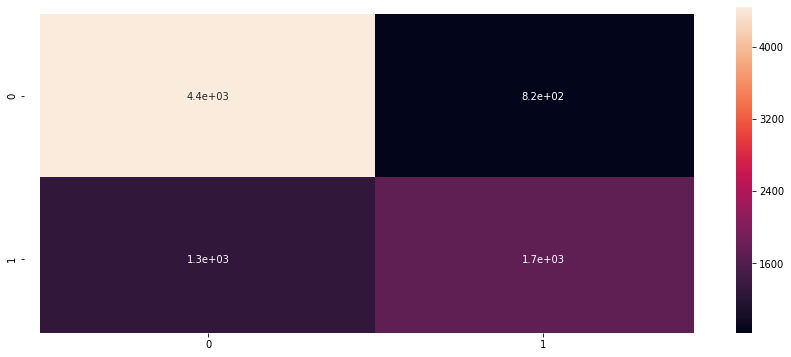

In [136]:
#Matrice de confusion
confusion_matrice=confusion_matrix(y_test, y_pred_logistic_regression_model)
sns.heatmap(confusion_matrice, annot=True)
plt.xlim(-0.05, len(np.unique(y))-0.05)
plt.ylim(len(np.unique(y))-0.05, -0.05)
print(confusion_matrice)

### Random forest 

In [138]:
#Premier test 
classif = RandomForestClassifier(n_estimators=500, random_state=0,oob_score = True) 
random_forest_model=classif.fit(X_train, y_train)  
y_pred_random_forest_model = random_forest_model.predict(X_test)  

[[5212   59]
 [ 146 2878]]


(1.95, -0.05)

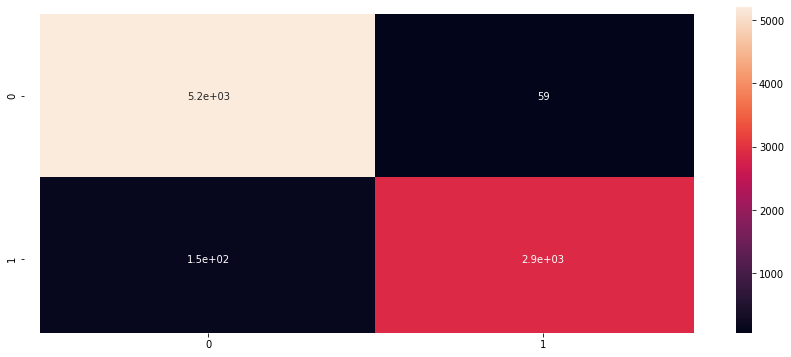

In [139]:
confusion_matrice=confusion_matrix(y_test, y_pred_random_forest_model)
print(confusion_matrice)
sns.heatmap(confusion_matrice, annot=True)
plt.xlim(-0.05, len(np.unique(y))-0.05)
plt.ylim(len(np.unique(y))-0.05, -0.05)

In [140]:
accuracy_score(y_train, random_forest_model.predict(X_train))

1.0

In [141]:
accuracy_score(y_test, y_pred_random_forest_model)

0.9752863170584689

In [142]:
#Proba d'appartenir à la classe 
y_pred_proba_random_forest_model=classif.predict_proba(X_test)
y_pred_proba_random_forest_model

array([[0.626, 0.374],
       [0.   , 1.   ],
       [0.996, 0.004],
       ...,
       [0.904, 0.096],
       [0.998, 0.002],
       [0.   , 1.   ]])

#### Gridsearch pour random forest 

In [144]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100],
    'max_features': [3, 4],
    'min_samples_leaf': [3, 4],
    'min_samples_split': [8, 10],
    'n_estimators': [100, 250, 500],
    'oob_score' : [True]
}


In [145]:
rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2) 

In [146]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   49.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:  4.6min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [147]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 4,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 500,
 'oob_score': True}

In [148]:
best_grid_random_forest = grid_search.best_estimator_
model_best_random_forest=best_grid_random_forest.fit(X_train, y_train) 
import pickle
filename = 'model_best_random_forest.pkl'
pickle.dump(model_best_random_forest, open(filename, 'wb'))
y_pred_classif_best_random_forest = model_best_random_forest.predict(X_test)  
y_pred_proba_classif_best_random_forest = model_best_random_forest.predict_proba(X_test)  

[[5244   27]
 [ 384 2640]]


(1.95, -0.05)

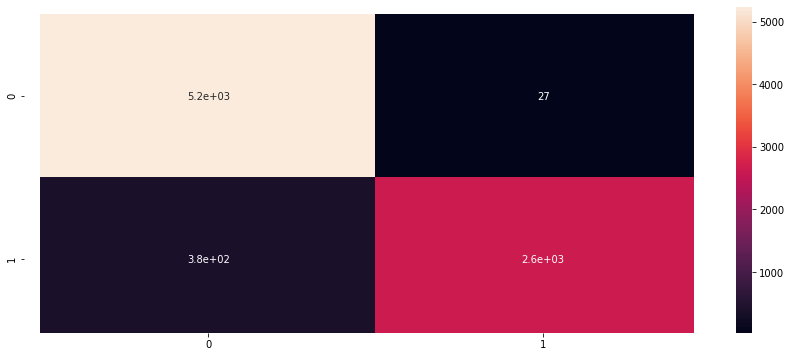

In [149]:
confusion_matrice_best_grid_random_forest=confusion_matrix(y_test, y_pred_classif_best_random_forest)
print(confusion_matrice_best_grid_random_forest)
sns.heatmap(confusion_matrice_best_grid_random_forest, annot=True)
plt.xlim(-0.05, len(np.unique(y))-0.05)
plt.ylim(len(np.unique(y))-0.05, -0.05)

In [150]:
accuracy_score(y_train, model_best_random_forest.predict(X_train))

0.9739311163895487

In [151]:
accuracy_score(y_test, y_pred_classif_best_random_forest)

0.9504520795660036

### SVM model

In [153]:
#Gaussian kernel
svclassifier = SVC(kernel='rbf',gamma='auto')
svclassifier.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [154]:
y_pred_svm_gaussian = svclassifier.predict(X_test)
print(confusion_matrix(y_test, y_pred_svm_gaussian))
print(classification_report(y_test, y_pred_svm_gaussian))


[[5267    4]
 [2888  136]]
              precision    recall  f1-score   support

         0.0       0.65      1.00      0.78      5271
         1.0       0.97      0.04      0.09      3024

    accuracy                           0.65      8295
   macro avg       0.81      0.52      0.44      8295
weighted avg       0.76      0.65      0.53      8295



In [155]:
#Sigmoid kernel 
svclassifier = SVC(kernel='sigmoid',gamma='auto')
svclassifier.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='sigmoid',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [156]:
y_pred_svm_sigmoid = svclassifier.predict(X_test)
print(confusion_matrix(y_test, y_pred_svm_sigmoid))
print(classification_report(y_test, y_pred_svm_sigmoid))


[[5271    0]
 [3024    0]]
              precision    recall  f1-score   support

         0.0       0.64      1.00      0.78      5271
         1.0       0.00      0.00      0.00      3024

    accuracy                           0.64      8295
   macro avg       0.32      0.50      0.39      8295
weighted avg       0.40      0.64      0.49      8295



### Xgboost

In [158]:
#Premier test 
model_xgboost = XGBClassifier()
model_xgboost.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [159]:
y_pred_xgboost = model_xgboost.predict(X_test)

In [160]:
accuracy_score(y_train, model_xgboost.predict(X_train))

0.996021377672209

In [161]:
accuracy_score(y_test, y_pred_xgboost)

0.9720313441832429

#### Gridsearch xgboost

In [163]:
param_grid_xgboost = {
    'max_depth': [5, 6, 7],
    'n_estimators': [100, 200],
    'learning_rate' : [0.2,0.3],
    'booster':['gbtree', 'gblinear','dart'],
    'gamma':[0,0.05]
}


In [164]:
model_xgboost = XGBClassifier()
grid_search_xgboost = GridSearchCV(estimator = model_xgboost, param_grid = param_grid_xgboost, cv = 3, n_jobs = -1, verbose = 2) 

In [165]:
grid_search_xgboost.fit(X_train, y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed: 17.2min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constrai...
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     validate_parameters=False,
                                     verbosity=None),
             iid='warn', n_jobs=-1,
             param_

In [166]:
grid_search_xgboost.best_params_

{'booster': 'gbtree',
 'gamma': 0.05,
 'learning_rate': 0.3,
 'max_depth': 6,
 'n_estimators': 200}

In [167]:
best_grid_xgboost = grid_search_xgboost.best_estimator_
model_best_xgboost=best_grid_xgboost.fit(X_train, y_train) 
filename = 'model_best_xgboost.pkl'
pickle.dump(model_best_xgboost, open(filename, 'wb'))
y_pred_classif_best_xgboost = model_best_xgboost.predict(X_test)  
y_pred_proba_classif_best_xgboost = model_best_xgboost.predict_proba(X_test)  

[[5170  101]
 [ 107 2917]]


(1.95, -0.05)

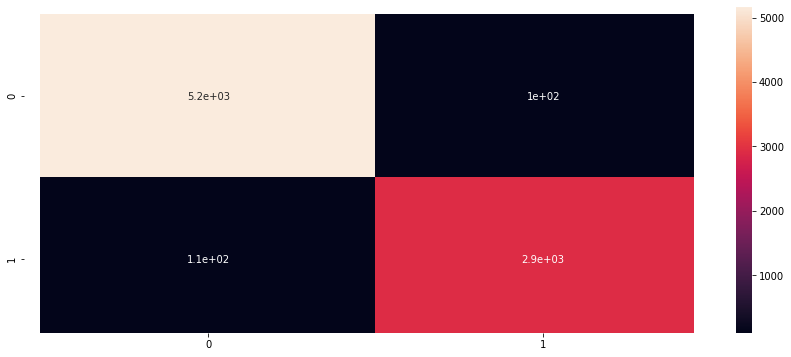

In [168]:
confusion_matrice_best_xgboost=confusion_matrix(y_test, y_pred_classif_best_xgboost)
print(confusion_matrice_best_xgboost)
sns.heatmap(confusion_matrice_best_xgboost, annot=True)
plt.xlim(-0.05, len(np.unique(y))-0.05)
plt.ylim(len(np.unique(y))-0.05, -0.05)

In [169]:
accuracy_score(y_train, model_best_xgboost.predict(X_train))

1.0

In [170]:
accuracy_score(y_test, y_pred_classif_best_xgboost)

0.974924653405666

In [171]:
log_loss(y_test, y_pred_proba_classif_best_xgboost)


0.0665960688969418

In [172]:
print(classification_report(y_test,y_pred_classif_best_xgboost))

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      5271
         1.0       0.97      0.96      0.97      3024

    accuracy                           0.97      8295
   macro avg       0.97      0.97      0.97      8295
weighted avg       0.97      0.97      0.97      8295

